# Brute Force Collaborative Filtering

Notebook to perform brute force collaborative filtering on the LastFM dataset. 

### About the dataset
The data contains the complete music listening history of 992 users on LastFM over a span of several years, with a total of 19.1M records. Every song played by each of the users is available along with the timestamps. For this collaborative filtering exercise, we work with an aggregated version with only users and artists.

### Collaborative filtering methodology
We employ a user-user neighborhood based collaborative filtering. Since this is 
1. Split the data into training and testing data. Split is done by keeping a hold out (20%) of artists for every user.
2. Find the similarity between all pairs of users in the training data. Here we use Pearson Correlation for similarity, owing to it's ease of calculation using Pandas
3. Determine the peers of every user. We use a paraemeter k to determine the number of closest neighbors to consider. This parameter is tuned.
4. Calculate a weighted average of all music interests of the neighbors (weighted by the correlation to user). The values are mean centered. 
5. This weighted average is added to the average count of the user to get the counts in the test data

### Model Evaluation
We use Root Mean Squared Error (RMSE) and Mean Abbsolute Error (MAE) of the test predicitons to select our model parameters.



In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

## Read Data

Read the dataset using Pandas and see what it looks like.

In [52]:
data = pd.read_csv("./lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv", 
                   delimiter="\t", header=None, 
                   names = ["userid","timestamp","musicbrainz-artist-id",
                            "artist-name","musicbrainz-track-id","track-name"])

In [53]:
print("Total number of rows:", len(data))
data.sample(5)

Total number of rows: 19098862


,userid,timestamp,musicbrainz-artist-id,artist-name,musicbrainz-track-id,track-name
14783634,user_000783,2007-02-26T21:48:44Z,22e981ec-110f-4a8c-a73c-1746eac4ca12,Black Funeral,NaN,Leviathan (The Roaring Black Oceans)
16808738,user_000870,2006-11-29T11:28:55Z,b21ef19b-c6aa-4775-90d3-3cc3e067ce6d,Serge Gainsbourg,dcffbf5a-7333-454f-ae42-7c1f44bbcab6,Daisy Temple
2716865,user_000137,2007-03-27T03:00:57Z,cbf9738d-8f81-4a92-bc64-ede09341652d,Chris Cornell,182060ce-23f0-4242-91de-f467a70067cb,You Know My Name
10026933,user_000535,2005-07-13T13:49:17Z,df360f0d-44bf-44c4-9b60-38d4fc13996a,Fc Kahuna,dee835d1-6abc-448c-96d6-187961d2088f,Hayling (Ils Remix)
5082085,user_000263,2008-05-14T18:43:07Z,bc91f8af-a6e5-46f3-b239-b5b1c390e535,The Glove,NaN,Perfect Murder (2006 Remastered Lp Version)


## Group data into artists and users

For part 1 of the project we will only be working with the grouped data at an artist level. We will not be incorporating timestamps or songs in this.

In [14]:
user_artist_groups = data.groupby(['userid','artist-name'])['timestamp'].count().reset_index()
user_artist_groups.columns = ['userid', 'artist-name', 'count']

Print the first 5 and last 5 rows of this grouped dataset

In [15]:
user_artist_groups.head(5)

,userid,artist-name,count
0,user_000001,2562,26
1,user_000001,310,1
2,user_000001,3582,1
3,user_000001,4 Wings,2
4,user_000001,4Hero,146


In [16]:
user_artist_groups.tail(5)

,userid,artist-name,count
897416,user_001000,Zigmat,1
897417,user_001000,Zion I,2
897418,user_001000,Zy-,2
897419,user_001000,浜崎あゆみ,1
897420,user_001000,長沼英樹,18


### Save the file!

Let's save this grouped data into a csv for later use

In [17]:
user_artist_groups.to_csv("users_and_artists.csv", index=False)

### Counting the number of artists and users in the dataset

In [18]:
unique_users = np.unique(user_artist_groups["userid"])
unique_artists = np.unique(user_artist_groups["artist-name"])

In [19]:
print('Number of unique users:', len(unique_users))
print('Number of unique artists:', len(unique_artists))

Number of unique users: 992
Number of unique artists: 173923


## Making Train-Test splits

Before proceeding further, it is important for us to make a train-test split of the dataset. The collaborative filter will be built on the training data only and tested on the test data. We use an 80-20 split which is done in a manner such that 20% of artists of each user are put in the test data. This ensures that 80% of the artists for each user is available for each user.

In [20]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()

In [21]:
user_artist_groups = pd.read_csv("users_and_artists.csv")

In [ ]:
# 20% artists for each user
for u in unique_users:
    user_u_all_data = user_artist_groups.loc[user_artist_groups["userid"]==u,:]
    user_u_train, user_u_test = train_test_split(user_u_all_data, test_size=0.20, random_state=42)
    train_data = train_data.append(user_u_train)
    test_data = test_data.append(user_u_test)

In [23]:
# write to csv
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

## Make the user-item count matrix using the training data

In [24]:
count_matrix = pd.DataFrame(columns = unique_users, index=unique_artists) #initialize with blanks

### Fill up the values of the matrix

In [25]:
for index, row in train_data.iterrows():
    count_matrix.loc[row['artist-name'], row['userid']] = row['count'] #fill each user-artist pair

In [26]:
count_matrix = count_matrix.astype(float) # ensure the dataframe is float type for correlation to work

In [27]:
count_matrix.to_csv("count_matrix.csv", index = True) # save this to a csv 

In [28]:
del data, user_artist_groups # clearing up some RAM

## Finding k most correlated users (nearest neighbors) for each user

This is the key step in the process of building a collaborative filter - generating the user-user similarity matrix. The similarity measure we emply here is the Pearson correlation, for its simplicity and ease of interpretability. We'll use the Pandas correlation method to create this similarity matrix. It is a useful funtion as it also handles sparse vectors well.

In [29]:
user_corr_matrix = count_matrix.corr() # create correlation matrix

In [30]:
user_corr_matrix.head(5) # first 5 rows

,user_000001,user_000002,user_000003,user_000004,user_000005,user_000006,user_000007,user_000008,user_000009,user_000010,...,user_000991,user_000992,user_000993,user_000994,user_000995,user_000996,user_000997,user_000998,user_000999,user_001000
user_000001,1.000000,-0.057230,0.427027,0.267180,-0.081073,0.342353,-0.109686,-0.430294,0.181502,-0.366927,...,-0.093730,-0.071619,0.380880,-0.251751,-0.047091,0.184118,-1.000000,0.929310,-0.018227,0.486616
user_000002,-0.057230,1.000000,0.006609,-0.031759,0.103367,0.110244,-0.159582,-0.213852,-0.073812,-0.214448,...,-0.018367,-0.042882,0.136112,0.297763,0.029010,-0.028058,-0.069850,0.156928,0.001762,0.274594
user_000003,0.427027,0.006609,1.000000,0.224455,0.202054,-0.028400,-0.068726,0.520668,0.111141,-0.030965,...,0.104279,-0.053574,-0.070045,0.222945,0.045960,0.208109,-0.327386,0.221143,-0.004975,0.038799
user_000004,0.267180,-0.031759,0.224455,1.000000,0.054552,-0.044578,0.087069,-0.280795,-0.055148,0.115495,...,-0.028945,0.209526,0.239227,-0.013614,0.096783,0.760990,-0.017256,0.625875,-0.043685,0.295971
user_000005,-0.081073,0.103367,0.202054,0.054552,1.000000,-0.059106,-0.129849,-0.120712,-0.082940,-0.040968,...,-0.513507,-0.053357,0.535216,0.102244,0.049824,-0.051752,-1.000000,-0.153929,-0.137953,-0.169765


In [31]:
user_corr_matrix.to_csv("user_corr_matrix.csv") # save to csv

### Visualizing peers

For every user, we will consider a peer set of k other users who are most correlated to the given user.
The graph below illustrates all pairs of users who are higly correlated. The users are the nodes and each edge represents a correlation above 95%. 

The plot was obtained using Gephy, a handy tool for visualizing graphs.

![Visualization of correlation between users](highly-correlated-users2.png)



## Predicting for test data

Let's use the correlation matrix to do predict the interest for every user in the artists we set aside

In [33]:
test_data = pd.read_csv("test_data.csv")

In [34]:
test_data.head(5) # preview

,userid,artist-name,count
0,user_000001,Yanokami,42
1,user_000001,Jeff Beck,15
2,user_000001,Jonny Greenwood,2
3,user_000001,Björk,448
4,user_000001,Ken Ishii,13


Let's define a few routines which would be required for making the predicitons

In [35]:
def get_user_nearest_neighbor_list(k, corr_matrix, user):
    """
    Function to find the K nearest neighbors (peer-set) for a given user
    
    :param k: Number of Neighbors, positive integer
    :param corr_matrix: The user correlation matrix, created on the training data, Pandas dataframe
    :param user: The user for whom neighbors have to be found, string
    :return: nearest_neighbors[:k], the k nearest neighbors, numpy array of strings
    """
    user_list = np.array(list(corr_matrix))
    user_correlations = np.array(corr_matrix.loc[user,:]) # get correlations to all other users
    nearest_neighbors_inds = np.argsort(user_correlations)[::-1] # sort by largest to smallest
    nearest_neighbors_inds = nearest_neighbors_inds[user_correlations[nearest_neighbors_inds] > 0] # consider only positive
    nearest_neighbors = user_list[nearest_neighbors_inds]
    nearest_neighbors = np.delete(nearest_neighbors, np.where(nearest_neighbors==user)[0]) 
    return nearest_neighbors[:k] # return k nearest

def find_means(count_matrix):
    """
    Function to find the average times a user listens to any given artist, for all users
    
    :param count_matrix: the user-artist matrix, pandas dataframe
    :return means, pandas Series 
    """
    user_list = list(count_matrix)
    means = count_matrix.mean()
    return means

def predict_test_recommendations(test_data, train_count_matrix, train_corr_matrix, n_neighbors):
    """
    Function to predict artist counts for all test users.
    
    :param test_data: The test data, pandas dataframe
    :param train_count_matrix: The user-artist matrix, pandas dataframe
    :param train_corr_matrix: The user-user correlation matrix, pandas dataframe
    :param n_neighbors: size of the peer-set to consider, postive integer
    
    :return test_prediction_table: prediction matrix for the test data, pandas dataframe
    :return root_mean_sq_error: RMSE value of the predicition, float
    :return mean_abs_error: MAE value of the prediction, float
    """
    test_true_counts = np.array([]) # empty initialize ground truth
    test_predicted_counts = np.array([]) # empty initialize predictions
    test_prediction_table = pd.DataFrame() # empty initialize prediction table
    
    test_users = np.unique(np.array(test_data["userid"])) # get list of all user-ids in test data
    mean_counts_of_users = find_means(train_count_matrix) # :pandas series: series of mean artist counts for each user
    
    # Find peer set for each user and predict based on peers' tastes
    for user in test_users:
        mean_user_counts = np.int8(mean_counts_of_users[user]) # user's mean counts, for centering
        # get list of k nearest neighbors (peer set) for the user
        peers = get_user_nearest_neighbor_list(k=n_neighbors, 
                                               corr_matrix=train_corr_matrix,
                                               user=user)
        peers_artist_counts = train_count_matrix.loc[:,peers] # artist counts of the peer-set
        mean_counts_of_peers = mean_counts_of_users[peers]
        peers_corrs = pd.Series()

        for nn in peers:
            peers_corrs[nn] = user_corr_matrix.loc[user, nn]
            peers_artist_counts.loc[:,nn] -= mean_counts_of_peers[nn] # mean centering
            peers_artist_counts.loc[:,nn] *= peers_corrs[nn] # weighted by correlation value

        user_count_predictions_all_artists = peers_artist_counts.sum(axis=1)/peers_corrs.sum() # weighted average across all peers  
        user_test_data = test_data.loc[test_data["userid"]==user,:].loc[:,["artist-name","count"]]    
        user_test_data_series = pd.Series(data = np.array(user_test_data["count"]), index = np.array(user_test_data["artist-name"]))
        # Find predicitons only artists in the test set:
        user_count_predictions_test_artists = user_count_predictions_all_artists[user_test_data_series.index]
        user_count_predictions_test_artists += mean_user_counts # add the mean back
        # put predicitons into a table
        test_predicted_counts = np.append(test_predicted_counts,np.ravel(np.array(user_count_predictions_test_artists)))
        test_true_counts = np.append(test_true_counts,np.ravel(np.array(user_test_data["count"])))
        user_test_data["predicted-counts"] = np.ravel(np.array(user_count_predictions_test_artists))
        test_prediction_table = test_prediction_table.append(user_test_data)
    # Calculate RMSE and MAE
    root_mean_sq_error = np.sqrt(MSE(test_true_counts[~np.isnan(test_predicted_counts)], # only for non-NaN values
                                     test_predicted_counts[~np.isnan(test_predicted_counts)]))
    mean_abs_error = MAE(test_true_counts[~np.isnan(test_predicted_counts)],
                         test_predicted_counts[~np.isnan(test_predicted_counts)])
    return test_prediction_table, root_mean_sq_error, mean_abs_error
    

## What K works best?

Let's run the CF for different values of K (size of peer-set) and see how the relative performance of the metrics (RMSE and MAE) look for the test data

In [37]:
k_values = [1, 2, 5, 10, 20, 50, 100]
rmses = np.zeros(len(k_values))
maes = np.zeros(len(k_values))
for i, k in enumerate(k_values):
    _, rmses[i], maes[i] = predict_test_recommendations(test_data,count_matrix,user_corr_matrix, k) 
    

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


Let's put the results into a dataframe

In [58]:
metric_table = pd.DataFrame({'K':[str(x) for x in k_values], 'RMSE':rmses, 'MAE': maes})
metric_table

,K,MAE,RMSE
0,1,27.349993,134.973686
1,2,27.232644,112.247534
2,5,27.269896,107.418270
3,10,27.243184,104.629164
4,20,27.207705,103.545891
5,50,27.132056,102.701092
6,100,27.133519,102.382434


There seems to very little improvement in the MAE values with increasing k. The RMSE values appear to improve though. The results would make more sense once we benchmark them against a baseline prediction.

## Baseline Predicitons

We define the baseline predicition as the average number of times a user listened to. For example, if user A listened to Led Zeppelin 50 times, Pink Floyd 30 times and Guns&Roses 40 times, the baseline prediciton for any other artist would be the average of 30, 40 and 50 = 40.

In [44]:
def predict_baseline_recommendations(test_data, train_count_matrix):
    """
    Function to predict baseline predicitons for all test users.
    
    :param test_data: The test data, pandas dataframe
    :param train_count_matrix: The user-artist matrix, pandas dataframe
    
    :return test_prediction_table: baseline prediction matrix for the test data, pandas dataframe
    :return root_mean_sq_error: RMSE value of the baseline, float
    :return mean_abs_error: MAE value of the baseline, float
    """
    
    test_true_counts = np.array([]) # empty initialize ground truth
    test_predicted_counts = np.array([]) # empty initialize predictions
    test_prediction_table = pd.DataFrame() # empty initialize prediction table
    
    test_users = np.unique(np.array(test_data["userid"])) # get list of all user-ids in test data
    mean_counts_of_users = find_means(train_count_matrix) # :pandas series: series of mean artist counts for each user
    
    # Find peer set for each user and predict based on peers' tastes
    for user in test_users:
        mean_user_counts = np.int8(mean_counts_of_users[user]) # user's mean counts, for centering    
        user_test_data = test_data.loc[test_data["userid"]==user,:].loc[:,["artist-name","count"]]    
        user_test_data_series = pd.Series(data = np.array(user_test_data["count"]), index = np.array(user_test_data["artist-name"]))
        user_test_preds = mean_user_counts * np.ones(len(user_test_data)) # AVERAGE VALUES!
        test_predicted_counts = np.append(test_predicted_counts,user_test_preds)
        test_true_counts = np.append(test_true_counts,np.ravel(np.array(user_test_data["count"])))
        user_test_data["predicted-counts"] = user_test_preds
        test_prediction_table = test_prediction_table.append(user_test_data)
    
    root_mean_sq_error = np.sqrt(MSE(test_true_counts[~np.isnan(test_predicted_counts)], 
                                     test_predicted_counts[~np.isnan(test_predicted_counts)]))
    mean_abs_error = MAE(test_true_counts[~np.isnan(test_predicted_counts)],
                         test_predicted_counts[~np.isnan(test_predicted_counts)])
    return test_prediction_table, root_mean_sq_error, mean_abs_error

Let's calculate the baseline RMSE and MAE

In [45]:
_, baseline_rmse, baseline_mae = predict_baseline_recommendations(test_data,count_matrix)

In [46]:
baseline_rmse

102.98551732270417

In [47]:
baseline_mae

26.94809757833174

## Plot the results 

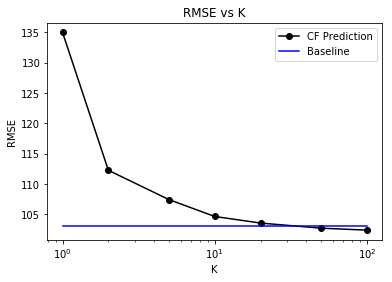

In [71]:
plt.plot(k_values, rmses, '-ko', label='CF Prediction')
plt.plot(k_values, baseline_rmse* np.ones(len(rmses)), '-b', label='Baseline')

plt.xscale('log')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.title("RMSE vs K")
plt.legend(loc='upper right')
plt.show()

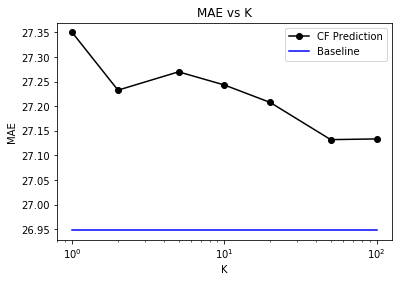

In [72]:
plt.plot(k_values, maes, '-ko',  label='CF Prediction')
plt.plot(k_values, baseline_mae* np.ones(len(maes)), '-b', label='Baseline')
plt.xscale('log')
plt.xlabel('K')
plt.ylabel('MAE')
plt.title("MAE vs K")
plt.legend(loc='upper right')
plt.show()

##### The CF model fails to beat the baseline when evaluated on MAE. It does however,  outperform the baseline when evaluated on RMSE.